In [1]:
from import_all import *
from utilities import *


In [2]:
#----Connect to instrument----#
#load the station from yaml configuration file
station = Station(config_file="electrochemistry.station.yaml")
keithley1 = station.load_keithley1()
keithley2 = station.load_keithley2()
# nano1 = station.load_nanovoltmeter1()
# nano2 = station.load_nanovoltmeter2()

Connected to: Keithley Instruments Inc. 2636B (serial:4629010, firmware:3.4.0) in 0.30s
Connected to: Keithley Instruments Inc. 2614B (serial:4070377, firmware:3.0.4) in 0.35s


In [3]:
#----Save paths----#
csv_save_path = "../csv/250901/"
db_save_path = "../db/250901/"
device_name = "s126 gr hbn 5um" #master database file
xpmnt_name = "endurance squareWave_twoStage_n(0.05_4-1V)_E(m0-1) dt 1 50C"#xpmnt name within database. Saved as seperate csv

In [4]:
####################################
#----Configure channels----#
####################################

# Note that when adding new channels, if "temperature" or "nano" in dictionary "name", program
# will handle the channel as a temperature measurement or nanovoltmeter, respectively.


ch1 = { "channel": keithley1.smua,
        "name": "top_gate",
        "vlow": -0.15,
        "vmid": -0.15,
        "vhigh":0.5,
        "nlow": 0,
        "nmid":10,
        "nhigh": 12,
        "nramp":0,
        "noffset":0,
        "modSin": False,
        "nPSin": 10,
        "ampSin": 0.025,
        "cycSin": 1,
        "independent":  False,
        "manual": False,
        "manual_vRange": [],
        "rampBool": False,
               
}

ch2 = { "channel": keithley1.smub,
        "name": "bottom_gate",
        "vlow": 0.15,
        "vmid": 0.15,
        "vhigh":2.15,
        "nlow": 0,
        "nmid":10,
        "nhigh": 12,
        "nramp":0,
        "noffset":0,
        "modSin": False,
        "nPSin": 10,
        "ampSin": 0,
        "cycSin": 1,
        "independent":  False,
        "manual": False,
        "manual_vRange": [],
        "rampBool": False,
}

ch3 = { "channel": keithley2.smub,
        "name": "drain_source",
        "vlow":0.001,
        "vhigh": 0.001,
        "vmid":0.001,
        "nlow": 0,
        "nmid":10,
        "nhigh": 12,
        "nramp":0,
        "noffset":0,
        "modSin": False,
        "nPSin": 10,
        "ampSin": 0.025,
        "cycSin": 1,
        "independent":  False,
        "manual": False,
        "manual_vRange": [],
        "rampBool": False,
}

# ch4 = { "channel": keithley2.smua,
#         "name": "drain_source2",
#         "minV": 0.0002,
#         "maxV": 0.0002,
#         "nlow": 10,
#         "nhigh": 10,
#         "nramp":10,
#         "noffset":0,
#         "independent":  False,
#         "manual": False,
#         "manual_vRange": [],
#         "rampBool": True,
# }

# ch5 = { "channel": nano1,
#         "name": "nano1", 
#         "independent":  False      

# }


####################################
#----Configure global sweeping params----#
####################################

time_independent = True  #plot time as indepent variable? 
ncycles = 3 # how many cycles of square wave

#sine wave params
m_nPoints = 20
m_cycles = 1
m_amplitude = 0.025
mod_TG = True


#timing
dt = 1/2 #time of measurements
delayNPLC_ratio = 0.8 #ratio delay/integrate
n_measurements = 3 #how many measurements are performed. should not be tuned, should reflect setup

start_delay = 2
write_period = 1
round_delay= 0

ramp_up = True # ramp to initial values?
ramp_down = False #ramp back to 0?

three_stage = True

#Sweep order determines hierarchy of sweeping: Sweep 1st element; 
#for every 1st element, sweep second element; for every second element, sweep third element
sweepers = [ch1, ch2,ch3]
sweepers_save_order = [ch1, ch2,ch3] #Order for saving in database, for easy parsing of data in plottr-inspectr

nPSin = 10
ampSin = 0.025
cycSin = 1

In [5]:
delay = dt*delayNPLC_ratio/n_measurements
nplc_set = dt*50*(1-delayNPLC_ratio)/(n_measurements)

sweepers_save_order[0]["channel"].delay(n_measurements*delay)
sweepers_save_order[0]["channel"].nplc(nplc_set)

for sweeper in sweepers_save_order[1:]:
    sweeper["channel"].delay(0)
    sweeper["channel"].nplc(nplc_set)

In [6]:
from itertools import repeat
def pad_dicts(*dicts, key1 = "v_range"):
    max_length = max(len(d[key1]) for d in dicts if key1 in d)
    
    for d in dicts:
        if key1 in d and len(d[key1]) < max_length:
            padding = repeat(d[key1][-1], max_length - len(d[key1])) if d[key1] else repeat(None, max_length - len(d[key1]))
            d[key1].extend(padding)

def sinewave(nPoints, amplitude, cycles):
    length = np.pi * 2 * cycles
    return amplitude*np.sin(np.arange(0, length, length / nPoints))

def square_wave(dt, nlow, nhigh, vlow, vhigh, nramp, ncycles = 1,nshift = 0):
    low = vlow*np.ones(nlow)
    high = vhigh*np.ones(nhigh)
    rampup = np.linspace(vlow,vhigh,nramp)
    rampdown = np.linspace(vhigh, vlow, nramp)
    wave = np.concatenate((low,rampup,high,rampdown))
    wave = np.roll(wave, nshift)
    wave = np.tile(wave,ncycles)
    return wave

def add_sin(sin, original):
    toreturn = []
    for x in original:
        for y in sin:
            z = x+y
            toreturn.append(z)
    return np.array(toreturn)


def square_wave_three_stage_mod(dt, nlow, nhigh, nmid, vlow, vhigh, vmid, nramp, nPSin =1, ampSin=0, cycSin=1, ncycles = 1,nshift = 0):
    sin_mod = sinewave(nPSin, ampSin, cycSin)
    low = vlow*np.ones(nlow)
    high = vhigh*np.ones(nhigh)
    mid = vmid*np.ones(nmid)
    
    high= add_sin(sin_mod, high)
    mid = add_sin(sin_mod, mid)
    low= add_sin(sin_mod, low)

    rampup1 = np.linspace(vmid,vhigh,nramp)
    rampdown1 = np.linspace(vhigh, vmid, nramp)
    rampdown2 = np.linspace(vmid, vlow, nramp)
    rampup2 = np.linspace(vlow, vmid, nramp)
    wave = np.concatenate((mid, rampup1, high, rampdown1, mid, rampdown2, low, rampup2))
    wave = np.roll(wave, nshift)
    wave = np.tile(wave,ncycles)
    # wave = np.concatenate(wave, rampup2, mid)
    return wave


def square_wave_three_stage(dt, nlow, nhigh, nmid, vlow, vhigh, vmid, nramp, ncycles = 1,nshift = 0):
    low = vlow*np.ones(nlow)
    high = vhigh*np.ones(nhigh)
    mid = vmid*np.ones(nmid)
    rampup1 = np.linspace(vmid,vhigh,nramp)
    rampdown1 = np.linspace(vhigh, vmid, nramp)
    rampdown2 = np.linspace(vmid, vlow, nramp)
    rampup2 = np.linspace(vlow, vmid, nramp)
    wave = np.concatenate((mid, rampup1, high, rampdown1, mid, rampdown2, low, rampup2))
    wave = np.roll(wave, nshift)
    wave = np.tile(wave,ncycles)
    return wave



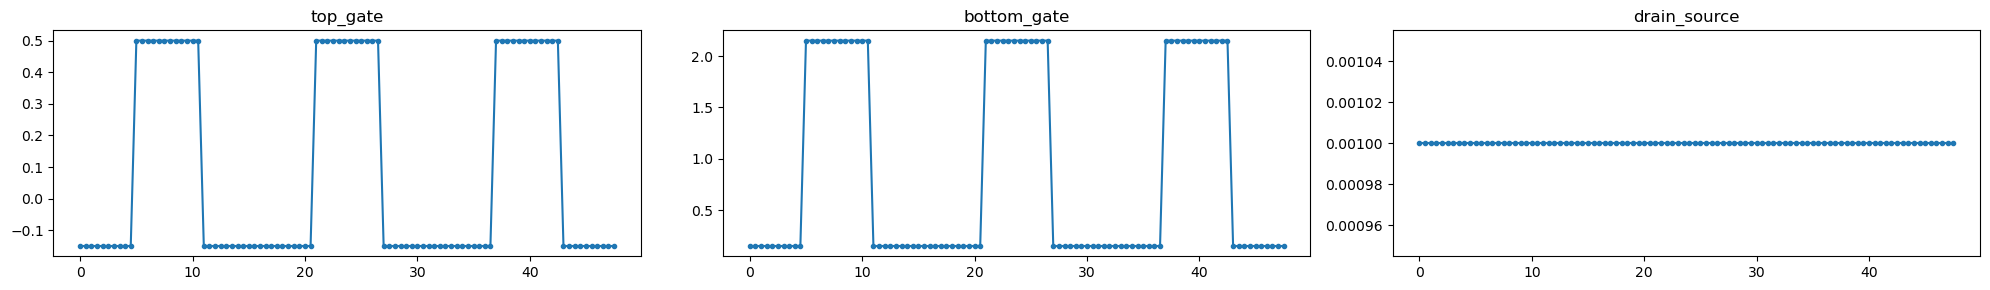

In [7]:
#####set scan lists and plot
i = 0
fig = plt.figure(figsize=(20, 3))
for sweeper in sweepers:
    vlow = sweeper["vlow"]
    vhigh = sweeper["vhigh"]
    vmid = sweeper["vmid"]
    nlow = sweeper["nlow"]
    nhigh = sweeper["nhigh"]
    nmid = sweeper["nmid"]
    nramp = sweeper["nramp"]
    noffset = sweeper["noffset"]

    rampBool = sweeper["rampBool"]
    
    if three_stage:
        if sweeper["modSin"]:
            nPSin = sweeper["nPSin"]
            ampSin = sweeper["ampSin"]
            cycSin = sweeper["cycSin"]
            sweeper["v_range"] =  square_wave_three_stage_mod(dt,nlow,nhigh,nmid,vlow,vhigh,vmid, nramp,ncycles = ncycles, nshift = noffset, nPSin = nPSin, ampSin = ampSin, cycSin = cycSin)
        else:
            sweeper["v_range"] =  square_wave_three_stage(dt,nlow,nhigh,nmid,vlow,vhigh,vmid, nramp,ncycles = ncycles, nshift = noffset)   #square_wave(dt, duration, p, delay, maxV, minV, dVramp)
    
    else:
        sweeper["v_range"] =  square_wave(dt,nlow,nhigh,vlow,vhigh,nramp,ncycles = ncycles, nshift = noffset)   #square_wave(dt, duration, p, delay, maxV, minV, dVramp)
    
    sweeper["v_range"] = list(sweeper["v_range"])
    
    if sweeper["manual"]:
        sweeper["v_range"] = sweeper["manual_vRange"]

pad_dicts(*sweepers, key1 = "v_range")

for sweeper in sweepers:
    sweeper["time"] = dt*np.arange(len(sweeper["v_range"]))
    ax = fig.add_subplot(1,len(sweepers),i+1)
    ax.plot(sweeper["time"], sweeper["v_range"], marker = '.')
    ax.set_title(sweeper["name"])
    i+=1

fig.tight_layout()



In [8]:
#----Connect to database----#
initialise_or_create_database_at(f'{db_save_path}{device_name}_squareWave.db')
#Set up experiment object
test_exp = load_or_create_experiment(
    experiment_name=xpmnt_name,
    sample_name=device_name,
)

meas_forward, time, independent_params = setup_database_registers_arb(station, test_exp, sweepers_save_order, time_independent=time_independent)
meas_forward.write_period = write_period


In [9]:
# ramp voltages to initial values, from 0
# initial values: 

x_initial = sweepers[0]["v_range"][0]
y_initial = sweepers[1]["v_range"][0]

if ramp_up:
    x_current = ch1["channel"].volt()
    y_current = ch2["channel"].volt()
    ramp_two_voltage(ch1["channel"],ch2["channel"], x_initial, y_initial, x_initial = x_current, y_initial = y_current, reset=False)

# if ramp_up:
#     for sweeper in sweepers:
#         if not "nano" in sweeper["name"]:
#             print(f'ramping {sweeper["name"]} to {sweeper["v_range"][0]}')
#             ramp_voltage(sweeper["channel"], sweeper["v_range"][0], rampdV = 5e-5, rampdT = 1e-4)

print(f'Delay for {start_delay} s...')
sleep(start_delay)
print("Starting sweeps")
time.reset_clock()

v_ranges = [d["v_range"] for d in sweepers]
with meas_forward.run() as forward_saver:
    first_sweep = True
    for i in range(len(sweepers[0]["v_range"])):
        for sweeper in sweepers:
            x = sweeper["v_range"][i]
            if not "nano" in sweeper["name"]:
                sweeper["channel"].volt(x)
                sweeper["voltage"] = x
        if first_sweep:
            print(f'Sleeping for {round_delay} s, beginning of new back-forward trace')
            sleep(round_delay)
            first_sweep = False
        

        t = time()
        get_readings = []
        independent_params = []
        for sweeper in sweepers_save_order:
            if "nano" in sweeper["name"]:
                v = sweeper["channel"].volt()
            else:
                v = sweeper["voltage"]
                j = sweeper["channel"].curr()
                get_readings.append((sweeper["channel"].curr, j))

            if sweeper["independent"]:
                independent_params.append((sweeper["channel"].volt, v))

            if not sweeper["independent"]:
                get_readings.append((sweeper["channel"].volt, v))

            if "temperature" in sweeper["name"]:
                temperature = rToT(v/j)
                get_readings.append((sweeper["channel"].temperature, temperature))

            
        independent_params.append((time,t))
        forward_saver.add_result(
            *independent_params,
            *get_readings,
            )
            
                
data_forward = forward_saver.dataset

#save data to csv
data_forward.to_pandas_dataframe().to_csv(f"{csv_save_path}{device_name}{xpmnt_name}_{data_forward.run_id}_manual_sweep.csv")

# Ramping voltage back to 0

if ramp_down:
    for sweeper in sweepers:
        if not "nano" in sweeper["name"]:
            print(f'ramping {sweeper["name"]} to 0')
            ramp_voltage(sweeper["channel"], 0)

ramping <Keithley2600Channel: keithley1_smua of Keithley2600: keithley1> and <Keithley2600Channel: keithley1_smub of Keithley2600: keithley1> to -0.15 and 0.15
Delay for 2 s...
Starting sweeps
Starting experimental run with id: 77. 
Sleeping for 0 s, beginning of new back-forward trace
